In [1]:
from transformers import ViTConfig, BertConfig, VisionTextDualEncoderConfig, VisionTextDualEncoderModel
from transformers import AutoProcessor, AutoModelForCausalLM, AutoTokenizer
import requests
from PIL import Image
import warnings
import torch
warnings.filterwarnings('ignore')

cuda_id = 1

/home/ubuntu/.conda/envs/chitb/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# GIT

In [34]:
base_processor = AutoProcessor.from_pretrained("microsoft/git-base-coco")
vqa_processor = AutoProcessor.from_pretrained("microsoft/git-base-textvqa")
tokenizer = AutoTokenizer.from_pretrained("microsoft/git-base-coco")
GIT_base = AutoModelForCausalLM.from_pretrained("microsoft/git-base-coco").cuda(cuda_id)
GIT_vqa = AutoModelForCausalLM.from_pretrained("microsoft/git-base-textvqa").cuda(cuda_id)


In [98]:
#IMAGE
url = "https://imglarger.com/Images/before-after/ai-image-enlarger-1-after-2.jpg"
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
caption_pixels = base_processor(images=image, return_tensors="pt").pixel_values
vqa_pixels = vqa_processor(images=image, return_tensors="pt").pixel_values

#Text
question = "What is the color of the glasses the girl wearing?"
print("Input shape:", caption_pixels.shape, vqa_pixels.shape)


#caption
input_ids = base_processor(text=question, add_special_tokens=False).input_ids
input_ids = [base_processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)
generated_ids = GIT_base.generate(pixel_values=caption_pixels.cuda(cuda_id), max_length=50)
caption = base_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

#vqa
input_ids = vqa_processor(text=question, add_special_tokens=False).input_ids
input_ids = [vqa_processor.tokenizer.cls_token_id] + input_ids
input_ids = torch.tensor(input_ids).unsqueeze(0)
generated_ids = GIT_vqa.generate(pixel_values=vqa_pixels.cuda(cuda_id), input_ids=input_ids.cuda(cuda_id), max_length=50)
answer = vqa_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

Input shape: torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 480, 480])


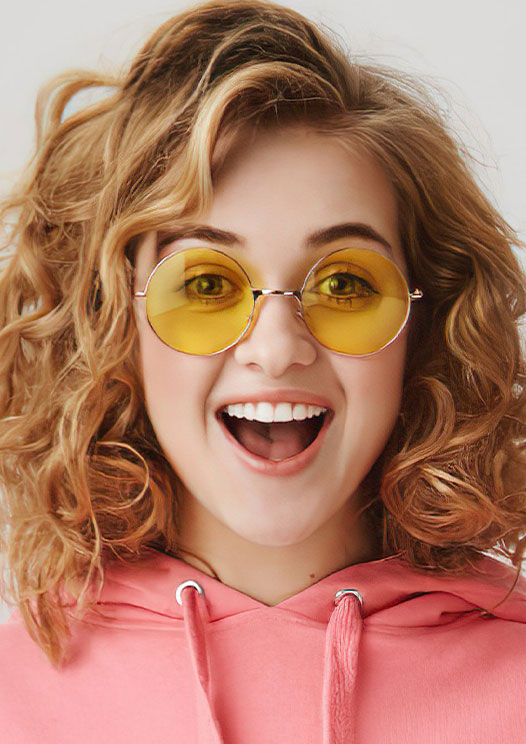

In [99]:
image

In [100]:
caption, answer

('a girl with a big smile',
 'what is the color of the glasses the girl wearing? answering does not require reading text in the image')

## BLIP 

In [2]:
import requests
from PIL import Image
from transformers import BlipProcessor, BlipModel, BlipForQuestionAnswering


processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-capfilt-large")
vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-capfilt-large").cuda(cuda_id)
blip_model = BlipModel.from_pretrained("Salesforce/blip-vqa-capfilt-large").cuda(cuda_id)
blip_model



Some weights of the model checkpoint at Salesforce/blip-vqa-capfilt-large were not used when initializing BlipModel: ['text_decoder.bert.encoder.layer.0.crossattention.self.value.weight', 'text_decoder.bert.encoder.layer.2.crossattention.output.LayerNorm.bias', 'text_encoder.encoder.layer.4.intermediate.dense.weight', 'text_encoder.encoder.layer.9.attention.self.key.bias', 'text_encoder.encoder.layer.5.crossattention.self.value.bias', 'text_encoder.encoder.layer.3.attention.self.key.weight', 'text_encoder.encoder.layer.5.attention.self.value.weight', 'text_encoder.encoder.layer.7.attention.self.query.bias', 'text_decoder.bert.encoder.layer.2.crossattention.self.value.bias', 'text_encoder.encoder.layer.3.output.LayerNorm.bias', 'text_encoder.encoder.layer.5.attention.output.LayerNorm.bias', 'text_decoder.bert.encoder.layer.5.attention.output.dense.bias', 'text_decoder.bert.encoder.layer.11.crossattention.output.dense.weight', 'text_encoder.encoder.layer.4.crossattention.self.key.bias', 

BlipModel(
  (text_model): BlipTextModel(
    (embeddings): BlipTextEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BlipTextEncoder(
      (layer): ModuleList(
        (0-11): 12 x BlipTextLayer(
          (attention): BlipTextAttention(
            (self): BlipTextSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BlipTextSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
         

In [4]:
url = "https://www.globaltimes.cn/Portals/0/attachment/2021/2021-03-11/13fb21ae-1a9c-4fb4-aa79-ca2c4a7131b4.jpeg" 
raw_image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

question = "Where are they sitting?"
inputs = dict([(k, v.cuda(cuda_id)) for k, v in processor(raw_image, question, return_tensors="pt").items()]) 

out = vqa_model.generate(**inputs, 
                     max_length=50)
answer = processor.decode(out[0], skip_special_tokens=True)
answer

'in car'

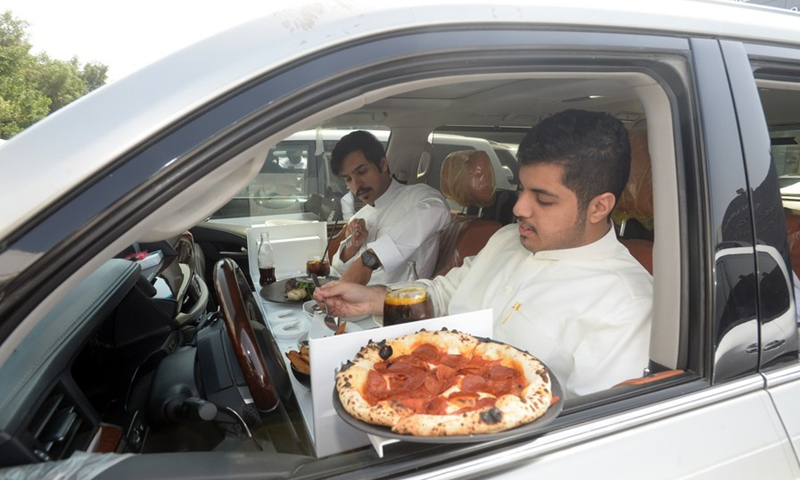

In [5]:
raw_image

In [6]:
answer

'in car'

## TEST MODEL 

In [7]:
blip_model

BlipModel(
  (text_model): BlipTextModel(
    (embeddings): BlipTextEmbeddings(
      (word_embeddings): Embedding(30524, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BlipTextEncoder(
      (layer): ModuleList(
        (0-11): 12 x BlipTextLayer(
          (attention): BlipTextAttention(
            (self): BlipTextSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BlipTextSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
         

In [13]:
outputs = blip_model(**inputs)

In [15]:
[(key, value.shape) if isinstance() for key, value in outputs.items()]

AttributeError: 'BaseModelOutputWithPoolingAndCrossAttentions' object has no attribute 'shape'